# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = " "   
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

No GPU found


In [2]:

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import Convolution2D, MaxPooling2D


In [3]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
from cv2 import resize
from mtcnn import MTCNN

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


First of all, you have you have to read the data. Run the cell below to unpack data.

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [4]:
import pandas as pd
from skimage.io import imread
from skimage.color import gray2rgb


def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    """Your implementation"""
    x_train, y_train, x_test, y_test = {}, {}, {}, {}
    #============== Train set ==============================================
    file_train_images = os.path.join(dir_name,'train','images')
    for filename in os.listdir(file_train_images):
        filename_img = os.path.join(dir_name,'train','images',filename)
        img = imread(filename_img)
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_train[filename] = img
        
    file_train_labels = os.path.join(dir_name,'train','y_train.csv')
    df_train = pd.read_csv(file_train_labels)
    for filename, class_id in zip(df_train['filename'],df_train['class_id']):
        y_train[filename] = class_id
    #============== Test set ==============================================
    file_test_images = os.path.join(dir_name,'test','images')
    for filename in os.listdir(file_test_images):
        filename_img = os.path.join(dir_name,'test','images',filename)
        img = imread(filename_img)
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_test[filename] = img
        
    file_test_labels = os.path.join(dir_name,'test','y_test.csv')
    df_test = pd.read_csv(file_test_labels)
    for filename, class_id in zip(df_test['filename'],df_test['class_id']):
        y_test[filename] = class_id
        
    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_test, y_test = load_image_data()
print ('%d'%len(x_train), '\ttraining images')
print ('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [6]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice( list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

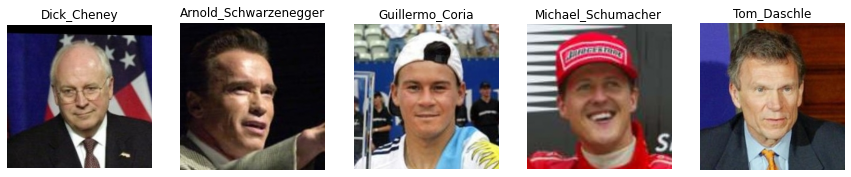

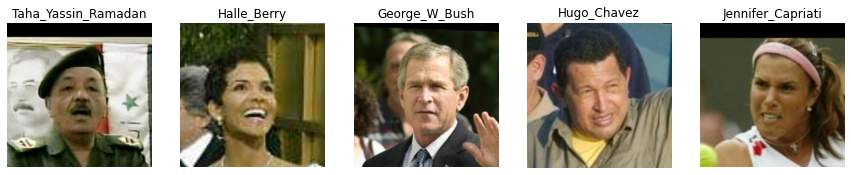

In [7]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [8]:
from skimage.color import gray2rgb
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    """Your implementation"""
    video_train, train_labels, video_test, test_labels = {},{},{},{}
    #============== Train set ==============================================
    file_train_images = os.path.join(dir_name,'train','images')
    for filename in os.listdir(file_train_images):
        filename_img = os.path.join(dir_name,'train','images',filename)
        img = imread(filename_img)
        if len(img.shape) == 2:
            img = gray2rgb(img)
        video_train[filename] = img
        
    file_train_labels = os.path.join(dir_name,'train','y_train.csv')
    df_train = pd.read_csv(file_train_labels)
    for filename, class_id in zip(df_train['filename'],df_train['class_id']):
        train_labels[filename] = class_id
    #============== Test set ===============================================
    folder_test_videos = os.path.join(dir_name,'test','videos')
    for foldername in os.listdir(folder_test_videos):
        video_test[foldername]=[]
        file_test_videos = os.path.join(dir_name, 'test', 'videos', foldername)
        for filename  in os.listdir(file_test_videos):
            filename_img = os.path.join(dir_name,'test','videos',foldername,filename)
            img = imread(filename_img)
            if len(img.shape) == 2:
                print('check shape')
                img = gray2rgb(img)
                
            video_test[foldername].append(img)
        
    file_test_labels = os.path.join(dir_name,'test','y_test.csv')
    df_test = pd.read_csv(file_test_labels)
    for filename, class_id in zip(df_test['filename'],df_test['class_id']):
        test_labels[str(filename)] = class_id
    
    
    
    return video_train, train_labels, video_test, test_labels

In [9]:
video_train, train_labels, video_test, test_labels = load_video_data()
print ('%d'%len(video_train), '\ttraining images')
print ('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


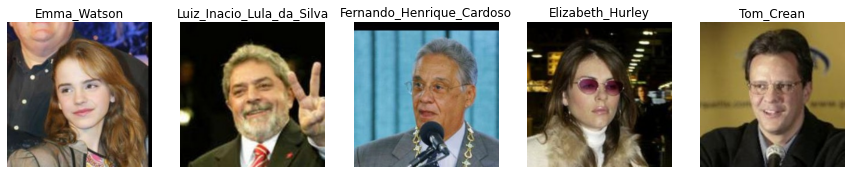

In [10]:
visualize(video_train, train_labels)

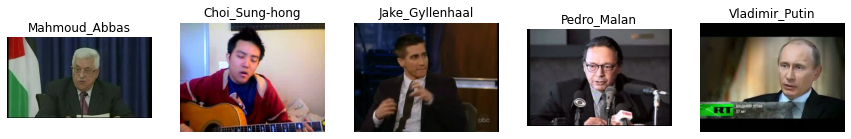

In [11]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [12]:

def preprocess_imgs_haar(imgs):
    """Your implementation"""
    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
    res = []   
    for img in imgs:
        img_size = np.asarray(img.shape)[0:2]
        img_center = img_size / 2
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect faces
        faces_haar = face_cascade.detectMultiScale(gray, 1.1, 5,minSize=(50, 50))
        if len(faces_haar) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            continue
        
        boxes=[]
        for face in faces_haar:
            x,y,w,h = face
            #roi_gray = gray[y:y+h, x:x+w]
            #eyes = eye_cascade.detectMultiScale(roi_gray)
            box_center = np.asarray([y+h/2.0,x+w/2.0])
            distance = np.linalg.norm(box_center-img_center)
            boxes.append((x,y,w,h,distance))
            
        boxes.sort(key=lambda tup: tup[4])
        #for i in range(len(boxes)):
        x,y,w,h = boxes[0][0:-1]
        top = max(0, int(y - h*0.2))
        bottom = min(img.shape[0], int(y + h*1.2))
        left = max(0,int(x-w*0.1))
        right = min(img.shape[1], int(x + w*1.1))
        #if top >= 0 and left >= 0:
        cropped = img[top:bottom, left:right, :]
        cropped = cv2.resize(cropped, (224, 224))
        res.append(cropped)
        #break

    return res

In [13]:
def preprocess_imgs_mtcnn(imgs):
    """Your implementation"""    
    res = []  
    realFaces = []
    mtcnn_face_detector = MTCNN()
    for img in imgs:
        img_size = np.asarray(img.shape)[0:2]
        img_center = img_size / 2
        faces_mtcnn = mtcnn_face_detector.detect_faces(img)
        realface= True
        if len(faces_mtcnn) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            realface= False
            realFaces.append(realface)
            continue
        realFaces.append(realface)
        boxes=[]
        for face  in faces_mtcnn:
            x, y, w, h = face['box']
            box_center = np.asarray([y+h/2.0,x+w/2.0])
            distance = np.linalg.norm(box_center-img_center)
            boxes.append((x,y,w,h,distance))
        boxes.sort(key=lambda tup: tup[4])
        
        x,y,w,h = boxes[0][0:-1]
        scale = 0.2
        top = max(0,int(y - h*scale))
        bottom = min(img.shape[0] ,int(y + (1+scale)*h))
        left = max(0, int(x - w*scale))
        right = min(img.shape[1] ,int(x + (1+scale)*w))

        cropped = img[top:bottom, left:right, :]
        cropped = cv2.resize(cropped, (224, 224))
        res.append(cropped)
            
        
    return res

In [14]:
def preprocess_videos_haar(imgs):
    """Your implementation"""
    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
    res = [] 
    realFaces = []
    for img in imgs:
        img_size = np.asarray(img.shape)[0:2]
        img_center = img_size / 2
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect faces
        faces_haar = face_cascade.detectMultiScale(gray, 1.1, 5,minSize=(50, 50))
        realface= True
        if len(faces_haar) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            realface= False
            realFaces.append(realface)
            continue
        realFaces.append(realface)
        
        boxes=[]
        
        for face in faces_haar:
            x,y,w,h = face
            #roi_gray = gray[y:y+h, x:x+w]
            #eyes = eye_cascade.detectMultiScale(roi_gray)
            box_center = np.asarray([y+h/2.0,x+w/2.0])
            distance = np.linalg.norm(box_center-img_center)
            boxes.append((x,y,w,h,distance))
            
        boxes.sort(key=lambda tup: tup[4])
        x,y,w,h = boxes[0][0:-1]
        top =  max(0,int(y - h*0.1))
        bottom = min(img.shape[0], int(y + h*1.1))
        left = max(0,int(x-w*0.1))
        right = min(img.shape[1], int(x + w*1.1))
        cropped = img[top:bottom, left:right, :]
        cropped = cv2.resize(cropped, (224, 224))
        res.append(cropped)

    return res,realFaces

In [15]:
def preprocess_videos_mtcnn(imgs):
    """Your implementation"""    
    res = []  
    realFaces = []
    mtcnn_face_detector = MTCNN()
    for img in imgs:
        img_size = np.asarray(img.shape)[0:2]
        img_center = img_size / 2
        faces_mtcnn = mtcnn_face_detector.detect_faces(img)
        realface= True
        if len(faces_mtcnn) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            realface= False
            realFaces.append(realface)
            continue
        realFaces.append(realface)
        boxes=[]
        for face  in faces_mtcnn:
            x, y, w, h = face['box']
            box_center = np.asarray([y+h/2.0,x+w/2.0])
            distance = np.linalg.norm(box_center-img_center)
            boxes.append((x,y,w,h,distance))
        boxes.sort(key=lambda tup: tup[4])
        
        x,y,w,h = boxes[0][0:-1]
        scale = 0.2
        top = max(0,int(y - h*scale))
        bottom = min(img.shape[0] ,int(y + (1+scale)*h))
        left = max(0, int(x - w*scale))
        right = min(img.shape[1] ,int(x + (1+scale)*w))

        cropped = img[top:bottom, left:right, :]
        cropped = cv2.resize(cropped, (224, 224))
        res.append(cropped)
            
        
    return res,realFaces


In [16]:
def preprocess_imgs(imgs,method='haar'):
    if method=='haar':
        res= preprocess_imgs_haar(imgs)
    elif method == 'mtcnn':
        res= preprocess_imgs_mtcnn(imgs)
    return res

In [17]:
def preprocess_videos(imgs,method='haar'):
    if method=='haar':
        res,realFaces= preprocess_videos_haar(imgs)
    elif method == 'mtcnn':
        res,realFaces= preprocess_videos_mtcnn(imgs)
    return res,realFaces

#### Visualization of preprocessing

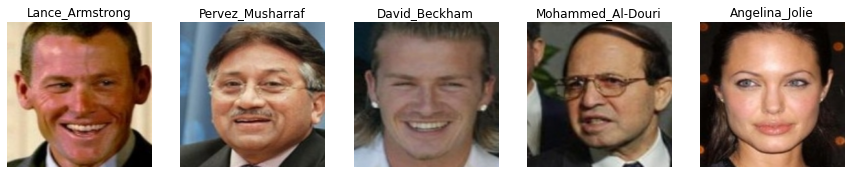

In [18]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

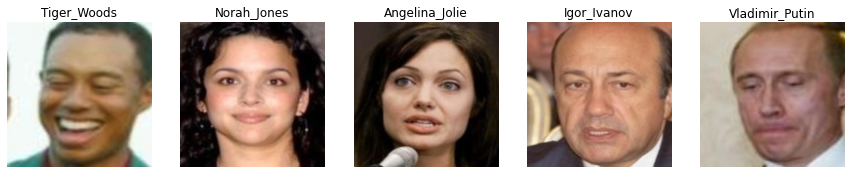

In [19]:
visualize(x_test, y_test, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [20]:
import h5py
from tensorflow.keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       2

In [21]:
for layer in model.layers:
    layer.trainable= False
for (i,layer) in enumerate(model.layers):
    print( "{} {} {} ".format(i,layer.__class__.__name__, layer.trainable))

0 Conv2D False 
1 Conv2D False 
2 MaxPooling2D False 
3 Conv2D False 
4 Conv2D False 
5 MaxPooling2D False 
6 Conv2D False 
7 Conv2D False 
8 Conv2D False 
9 MaxPooling2D False 
10 Conv2D False 
11 Conv2D False 
12 Conv2D False 
13 MaxPooling2D False 
14 Conv2D False 
15 Conv2D False 
16 Conv2D False 
17 MaxPooling2D False 
18 Flatten False 
19 Dense False 
20 Activation False 
21 Dense False 
22 Activation False 
23 Dense False 
24 Activation False 


In [22]:
def create_model(model,num_classes,layer = 'fc6/relu'):
    topmodel= model.get_layer(layer).output
    topmodel= Dense(512,activation='relu')(topmodel)
    #topmodel= Dense(256,activation='relu')(topmodel)
    topmodel= Dropout(0.3)(topmodel)
    topmodel= Dense(num_classes, activation='softmax')(topmodel)
    modelnew = Model(inputs=model.input,outputs=topmodel)
    return modelnew


Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [23]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [24]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Prepare_data

In [25]:
def prepare_data(mytrain_imgs,mytrain_labels,setCategories):
    X = []
    Y = []
    person2class= {person:cl for cl,person in enumerate(setCategories)}
    for i, img in mytrain_imgs.items():
        pre_img = preprocess_imgs([img])[0]
        X.append(pre_img)
        person = mytrain_labels[i]
        Y.append(int(person2class[person]))
        
    X = np.asarray(X).astype('float64') 
    Y = np.asarray(Y)
    return X,Y    

In [26]:
setCategories_imgs = set(y_train.values())
X_imgs_train,Y_imgs_train = prepare_data(x_train,y_train,setCategories_imgs)
X_imgs_test,Y_imgs_test = prepare_data(x_test,y_test,setCategories_imgs)


In [27]:
setCategories_videos = set(train_labels.values())
X_videos_train,Y_videos_train = prepare_data(video_train, train_labels,setCategories_videos)



In [28]:

person2class_imgs= {person:cl for cl,person in enumerate(setCategories_imgs)}
class2person_imgs = dict((v,k) for k,v in person2class_imgs.items())
person2class_videos= {person:cl for cl,person in enumerate(setCategories_videos)}
class2person_videos = dict((v,k) for k,v in person2class_videos.items())

### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [29]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
import logging
from os.path import join
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def scheduler(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    elif epoch < 15:
        return 0.0002
    else:
        return 0.0001

# class EpochModelCallback(tf.keras.callbacks.ModelCheckpoint):
#     def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=True,
#                  save_weights_only=False, mode='auto', save_freq='epoch'):
#         super().__init__(filepath, monitor=monitor, verbose=verbose, save_best_only=save_best_only,
#                          save_weights_only=save_weights_only, mode=mode, save_freq=save_freq)
#         self.filepath = filepath
#         self.ckpt = tf.train.Checkpoint(completed_epochs=tf.Variable(0, trainable=False,dtype='int64'))
#         self.ckpt_dir = os.path.join(os.path.dirname(filepath), "epoch_ckpt")
#         self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.ckpt_dir, max_to_keep=1)
#     def on_epoch_end(self, epoch, logs=None):
#         self.ckpt.completed_epochs.assign(epoch+1)
#         self.ckpt_manager.save()
#         # self.model.save(self.filepath)  ## Call the method of parent class to keep the advantage of save_best_only
#         super().on_epoch_end(epoch, logs)
#         print(f"Epoch checkpoint {self.ckpt.completed_epochs.numpy()}  saved to: {self.ckpt_manager.latest_checkpoint}")
#         print(logs)


class Classifier():
    def __init__(self, nn_model,D_out,class2person,flag_imgs=True):
        """Your implementation"""
        self.myModel = create_model(model,D_out)
        self.myModel.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
        self.myModel.summary()
        if flag_imgs:
            self.checkpoint_path = "training_imgs/cp-{epoch:04d}.ckpt"
        else:
            self.checkpoint_path = "training_videos/cp-{epoch:04d}.ckpt"
        
            
        self.checkpoint_dir = os.path.dirname(self.checkpoint_path)
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        self.cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= self.checkpoint_path,
                                                              save_weights_only=True,verbose=1,period=5)
        self.class2person = class2person
        
        
        
        
#         if flag_imgs:
#             MODEL_DIR = "model_traing_imgs"
#             self.model_path = os.path.join(MODEL_DIR, "mnist.h5")
#         else:
#             MODEL_DIR = "model_traing_videos"
#             self.model_path = os.path.join(MODEL_DIR, "faceModel.h5")
#         self.model_cbs = EpochModelCallback(self.model_path)


    def fit(self, X_train, Y_train,initial_epoch=0,BATCH_SIZE=64,TOTAL_EPOCHS=20):
        """Your implementation"""
        
#         model_path = self.model_path
#         # Restore checkpoint to get the already completed epoch. It will be the initial_epoch when resuming the training
#         epoch_callback = EpochModelCallback(model_path)
#         if epoch_callback.ckpt_manager.latest_checkpoint:
#             epoch_callback.ckpt.restore(epoch_callback.ckpt_manager.latest_checkpoint)
#             initial_epoch = epoch_callback.ckpt.completed_epochs.numpy()
#             print(initial_epoch)
#             logging.info(f"Restored epoch ckpt from {epoch_callback.ckpt_manager.latest_checkpoint}, completed epoch is {initial_epoch}")
#         else:
#             logging.info("Training from zero")
#             initial_epoch = 0
            
#         # restore model
#         if os.path.exists(model_path):
#             logging.info(f"Load existing model from {model_path} and resume training")
#             self.myModel = tf.keras.models.load_model(model_path)
#         else:
#             logging.info("Initializing from scratch.")

        self.myModel.fit(X_train,Y_train,
                         initial_epoch=initial_epoch,batch_size=BATCH_SIZE,epochs=TOTAL_EPOCHS,
                         verbose=1, callbacks=[self.cp_callback,self.lr_callback] )
        
    def load_model(self,cpk):
        self.myModel.load_weights(cpk)
        

    def classify_images(self, test_imgs):
        """Your implementation"""
        res = {}
        for i, img in test_imgs.items():
            pre_img = preprocess_imgs([img])[0]
            pre_img = pre_img[np.newaxis,:].astype('float64')
            predicted_y = self.class2person[np.argmax(self.myModel.predict(pre_img))]
            res[i] = predicted_y
       
        return res

       
        
    def classify_videos(self, test_video):
        """Your implementation"""
        res = {}
        for i, video in test_video.items():
            result = Counter()
            count=0
            for img in video:
                pre_imgs,realFaces = preprocess_videos([img])
                if (realFaces[0]):
                    pre_img = pre_imgs[0]
                    pre_img = pre_img[np.newaxis,:].astype('float64')
                    predicted_y = self.class2person[np.argmax(self.myModel.predict(pre_img))]
                    result[predicted_y] += 1
                    count +=1
            if(count==0):
                print('empty results')
            res[i] = max(result, key=lambda x:result[x])
        return res

        

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [30]:
img_classifier = Classifier(model,len(setCategories_imgs),class2person_imgs)
img_classifier.fit(X_imgs_train,Y_imgs_train)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [32]:
y_out = img_classifier.classify_images(x_test)

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [33]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [34]:
print (check_test(y_out, y_test))

Classification accuracy is 0.9431


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [35]:
video_classifier = Classifier(model,len(setCategories_videos),class2person_videos,flag_imgs=False)
video_classifier.fit(X_videos_train,Y_videos_train)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [36]:
y_video_out = video_classifier.classify_videos(video_test)
print (check_test(y_video_out, test_labels))

Classification accuracy is 0.7571
